<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from torchvision import models
import torch.nn as nn

In [32]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# プログレスバー導入
from tqdm import tqdm
import time

In [36]:
# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 店舗ごとに画像を読み込むように設定
# 標準化検討
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, score_path, transform=None):
        imgs = []
        distances = []
        scores = []

        # 標準化・正規化のクラスを定義
        ss_score = StandardScaler()
        ms_score = MinMaxScaler()
        ss_distance = StandardScaler()
        ms_distance = MinMaxScaler()
        
        with open (score_path, 'r') as infh:
            header = next(infh)
            for line in infh:
                d = line.replace('\n', "").split("\t")
                # 画像3枚
                three_imgs = []
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[0]))
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[1]))
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[2]))
                imgs.append(three_imgs)

                # 最寄りまでの距離
                distances.append(int(d[6]))
                
                if d[3] == '':
                    scores.append(float(0))
                else:
                    scores.append(float(d[3]))
        
        self.imgs = imgs

        scores = torch.from_numpy(np.array(scores)).float().view(-1, 1)
        scores = ss_score.fit_transform(scores) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        scores = ms_score.fit_transform(scores) #特徴量の最大値と最小値を計算し変換
        self.scores = torch.from_numpy(np.array(scores)).to(torch.float32).view(-1, 1)

        distances = torch.from_numpy(np.array(distances)).float().view(-1, 1)
        distances = ss_distance.fit_transform(distances) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        distances = ms_distance.fit_transform(distances) #特徴量の最大値と最小値を計算し変換
        self.distances = torch.from_numpy(np.array(distances)).to(torch.float32).view(-1, 1)
        
        self.ss_score = ss_score
        self.ms_score = ms_score
        
        self.transform = transform
        
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, i):
        img0 = PIL.Image.open(self.imgs[i][0]).convert("RGB")
        img1 = PIL.Image.open(self.imgs[i][1]).convert("RGB")
        img2 = PIL.Image.open(self.imgs[i][2]).convert("RGB")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return [img0, img1, img2, self.distances[i]], self.scores[i]

In [37]:
from torchvision.transforms.transforms import Resize
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_scores_20220306211034.tsv"
full_dataset = MyDataset(data_dir, transform=transform)

# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 標準化・正規化のクラスを定義
ss = StandardScaler()
ms = MinMaxScaler()
 
#fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
full_dataset.y = ss.fit_transform(full_dataset.y)

#特徴量の最大値と最小値を計算し変換
full_dataset.y = ms.fit_transform(full_dataset.y)
full_dataset.y = torch.from_numpy(full_dataset.y).to(torch.float32)

In [38]:
#　店舗ごとに分けられるように
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# # print(f"full: {len(full_dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
# 1店舗(3画像)1スコアでの出力
arch = "resnet50"
resnet_model = models.__dict__[arch](pretrained=True)

# 最後のfc層を削除（Identity()に変更）
resnet_model.fc = nn.Identity()

for p in resnet_model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# コードに変換可
print("各特徴量ごとの平均値は"+str(ss.mean_))
print("各特徴量ごとの標準偏差は"+str(ss.var_))

In [8]:
class CustomNet(torch.nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()

        self.sigmoid = torch.nn.Sigmoid()

        self.fc1 = torch.nn.Linear(3 * 2048, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])

        x = x.view(-1, 3 * 2048) # 多次元から1次元に無理やり戻しすぎ
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # sigmoid関数を使って0 - 1の値に変換する
        x = self.sigmoid(x)
        
        return x

custom_model = CustomNet()

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
custom_model = custom_model.to(device)
resnet_model = resnet_model.to(device)

# test
resnet_model.train()

data = next(iter(train_loader))
img0, img1, img2, scores = data
scores /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
scores = scores.to(device)
# optimizer.zero_grad()
output0 = resnet_model(img0)
output1 = resnet_model(img1)
output2 = resnet_model(img2)
torch.stack((output0, output1, output2), 1).size()

In [11]:
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

criterion = RMSELoss()


In [ ]:
train_loss = []
valid_loss = []
valid_scores = torch.tensor([]).to(device)
valid_outputs = torch.tensor([]).to(device)

for epoch in tqdm(range(50)):
  # 学習
#  そもそも勾配変化がしないのでなしでいい
#   resnet_model.train()
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      # custom_modelに入れ込む↓
      img0, img1, img2, scores = data
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      
      outputs = custom_model(outputs)
      # torch.Size([64, 3, 2048])
      loss = criterion(outputs, scores)
    #   print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
#   resnet_model.eval()
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:

      img0, img1, img2, scores = data
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      outputs = custom_model(outputs)
      # print("loss.item():{}\n".format(loss.item()))
      running_valid_loss += loss.item()
      valid_outputs = torch.cat((valid_outputs, outputs), 0)
      valid_scores = torch.cat((valid_scores, scores), 0)


  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

In [ ]:
train_loss = []
valid_loss = []
valid_scores = torch.tensor([]).to(device)
valid_outputs = torch.tensor([]).to(device)

for epoch in tqdm(range(50)):
  # 学習
#  そもそも勾配変化がしないのでなしでいい
#   resnet_model.train()
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      # custom_modelに入れ込む↓
      inputs, scores = data
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      
      outputs = custom_model(outputs)
      # torch.Size([64, 3, 2048])
      loss = criterion(outputs, scores)
    #   print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
#   resnet_model.eval()
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:

      img0, img1, img2, scores = data
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      scores = scores.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      outputs = custom_model(outputs)
      # print("loss.item():{}\n".format(loss.item()))
      running_valid_loss += loss.item()
      valid_outputs = torch.cat((valid_outputs, outputs), 0)
      valid_scores = torch.cat((valid_scores, scores), 0)


  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

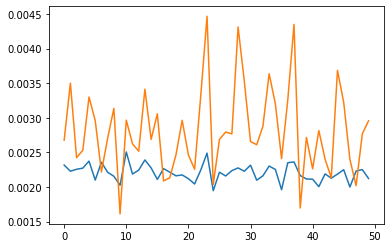

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

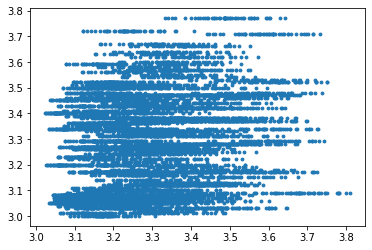

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
# 標準化・正規化を戻す
ss = full_dataset.ss_score
ms = full_dataset.ms_score
plot_outputs = ss.inverse_transform(ms.inverse_transform(valid_outputs.cpu().detach().numpy()))
plot_scores = ss.inverse_transform(ms.inverse_transform(valid_scores.cpu().detach().numpy()))
ax.scatter(plot_outputs, plot_scores, s=8)
fig.show()

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224

In [ ]:
class RegressionNet(torch.nn.Module):
    
    def __init__(self):
        super(RegressionNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 78 * 78, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # x = torch.nn.functional.relu(self.conv1(x))
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])
        x = self.conv1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.pool1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 159, 159])
        # x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.pool2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 78, 78])

        x = x.view(-1, 32 * 78 * 78) # 多次元から1次元に無理やり戻しすぎ
        x = self.relu(x) # 別の活性化関数に変更（tanhなど）
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print("x:{}".format(x))
        # sigmoid関数を使って0 - 1の値に変換する
        
        return x

In [ ]:
# 1画像1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

In [13]:
# test
resnet_model.train()

data = next(iter(train_loader))
img0, img1, img2, scores = data
scores /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
scores = scores.to(device)
# optimizer.zero_grad()
outputs = resnet_model(img0)
outputs.size()

torch.Size([64, 2048])